In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split as tts
import scipy.spatial.distance as dist_measure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [33]:
raw_data= pd.read_csv("iris.csv",names=['sepal_length','sepal_width','petal_length','petal_width','labels'])
raw_data.tail()

,sepal_length,sepal_width,petal_length,petal_width,labels
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [34]:
#encoding the the class labels
labelencoder= preprocessing.LabelEncoder()
raw_data['labels']= labelencoder.fit_transform(raw_data['labels'])
raw_data.tail()

,sepal_length,sepal_width,petal_length,petal_width,labels
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [35]:
#splitting the data into training set and test set using stratify sampling
X_train, X_test, y_train, y_test = tts(raw_data, raw_data['labels'], test_size=0.2,stratify=raw_data['labels'])
print (X_train.shape, y_train.shape)

(120, 5) (120,)


In [36]:
# the function which returns the result of the predictions 
#parameters: train set, test set, type of distance used for measurement, k which the number of the nearest neighbors


def k_nearest_neighbor(train_set,target_set,test_set,dist_type,k,**kwargs): 
    p = kwargs.get('p', 0)
    #calculate the distance between the points for each instance in test to the points in the training set
    Y=dist_measure.cdist(train_set.iloc[:,:4], test_set.iloc[:,:4],dist_type,p) 
    #converting to dataframe with columns as the test data index and indices as train set index
    #each entry in the dataframe represents the distance between [train_set instance][test_set_instance].
    Y=pd.DataFrame(Y)
    #creating the dictionary with the predicted value.
    answer={}
    #looping through each of the column(test set index) and getting the k nearest indices of the training set
    # and gettting the class label from the train set and using mode to predict the encoded class label.
    for test_point in Y.columns:
        indices=Y[test_point].nsmallest(k).index.to_list()
        predicted_label=[target_set.iloc[x] for x in indices ]
        answer[test_point]=predicted_label

    return pd.DataFrame(answer).mode().dropna().T.rename(columns={0:"predicted_label_value"}).astype({"predicted_label_value": 'int32'})


def test_prediction_results(predicted_value, actual_value,encoder,k):
    predicted_value['Actual_label_value']=list(actual_value)
    predicted_value['predicted_label']=encoder.inverse_transform(predicted_value['predicted_label_value'])
#     print(predicted_value)
    accuracy=accuracy_score(predicted_value['predicted_label_value'],predicted_value['Actual_label_value'] )
    print("Accuracy of this KNN classifer for k=%d is %f"%(k,accuracy))

def sklearn_knnClassifer(train,test,target,test_target,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train,target)
    print(neigh.predict(test))
    print('model avg mean accuracy: ',neigh.score(test,test_target))

# sklearn_knnClassifer(X_train,X_test,y_train,y_test,15)
# # sklearn_knnClassifer(X_train,X_test,y_train,20)

predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',3,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,3)



Accuracy of this KNN classifer for k=3 is 0.933333


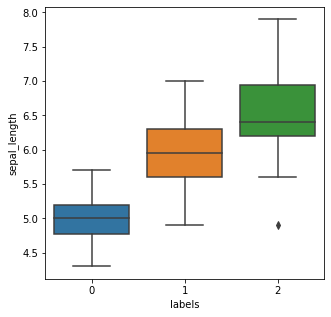

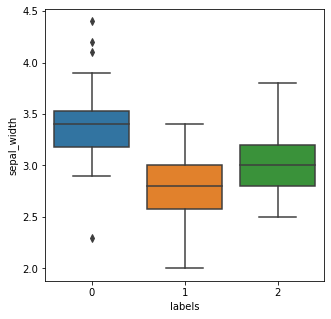

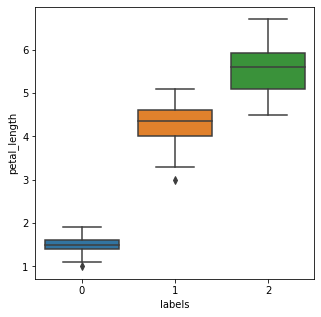

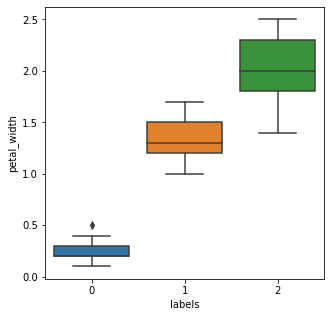

In [37]:
#Comparing the feature distribution using floowing function
def compare_features_by_class(X_train):
    for column in X_train.columns:
        if(column!='labels'):
            ax,fig=plt.subplots(figsize=(5,5))
            sns.boxplot(data=X_train, x='labels',y=column)
compare_features_by_class(X_train)


In [38]:
def plotly_compare_features_by_class(X_train):
    fig=go.Figure()
    for column in X_train.columns:
        if(column!='labels'):
            fig.add_trace(go.Box(x=X_train['labels'],y=X_train[column],name=column))
    fig.update_layout(boxmode='group')
    fig.show()
plotly_compare_features_by_class(X_train)

In [39]:
cmap_light = ListedColormap(['#FBBBB9', '#5EFB6E', '#82CAFF']) 
cmap_bold = ListedColormap(['#CA226B', '#387C44', '#2B65EC']) 
cmap_test = ListedColormap(['#8E35EF', '#FFFF00', '#659EC7'])
def decision_boundary_plot(train,target,test,test_target,k,p):
    
    train=train.iloc[:,:2]
    model = KNeighborsClassifier(n_neighbors=k,p=p)
    model.fit(train,target)
    #meshstep size parameter
    h=0.2
    
    x_min,x_max=train.iloc[:,0].min()-1,train.iloc[:,0].max()+1
    y_min,y_max=train.iloc[:,1].min()-1,train.iloc[:,1].max()+1
    
    xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    
    Z=model.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.figure(figsize=(10,5))
    plt.title("3-Class classification for k= %s"%(k));
    plt.xlabel(train.columns[0])
    plt.ylabel(train.columns[1])
    plt.pcolormesh(xx,yy, Z, cmap=cmap_light)
    plt.scatter(train.iloc[:,0],train.iloc[:,1],c=target,cmap=cmap_bold,edgecolor='k',s=40)
    plt.scatter(test.iloc[:,0],test.iloc[:,1],c=test_target,cmap=cmap_test,linewidth=1, marker='X',s=100)
    plt.show()
    
    


Accuracy of this KNN classifer for k=1 is 0.933333


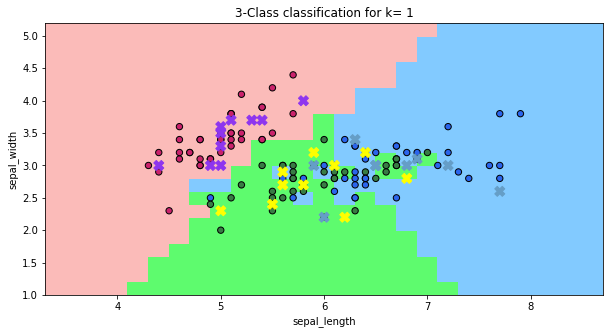

In [40]:
#b with k=1 plotting the decision boundaries
predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',1)
# predicted_labels=k_nearest_neighbor(X_train,X_test,'minkowski',1,p=3)


test_prediction_results(predicted_labels,y_test,labelencoder,1)
decision_boundary_plot(X_train,y_train,X_test,y_test,1,2)


Accuracy of this KNN classifer for k=2 is 0.933333


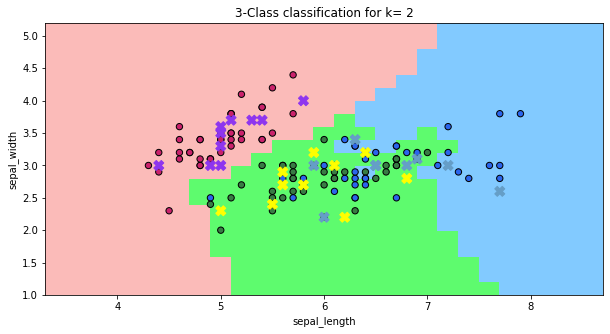

Accuracy of this KNN classifer for k=4 is 0.966667


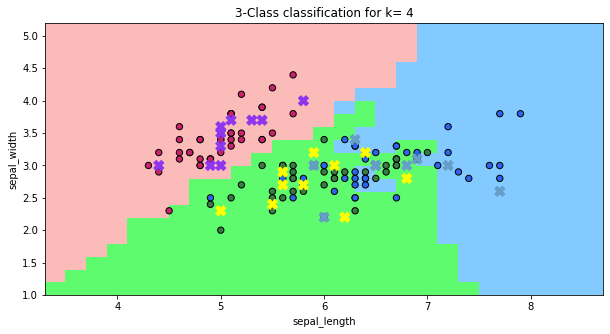

Accuracy of this KNN classifer for k=6 is 1.000000


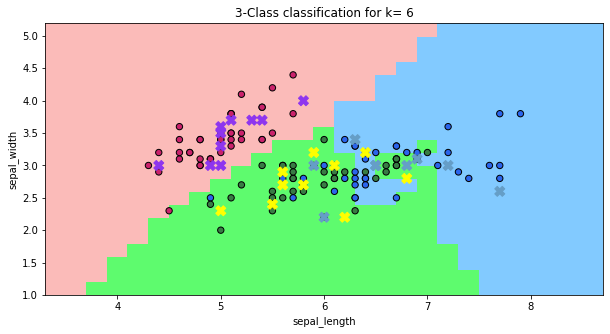

Accuracy of this KNN classifer for k=10 is 1.000000


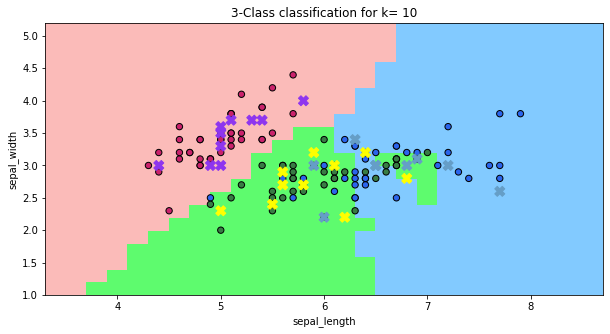

Accuracy of this KNN classifer for k=15 is 0.966667


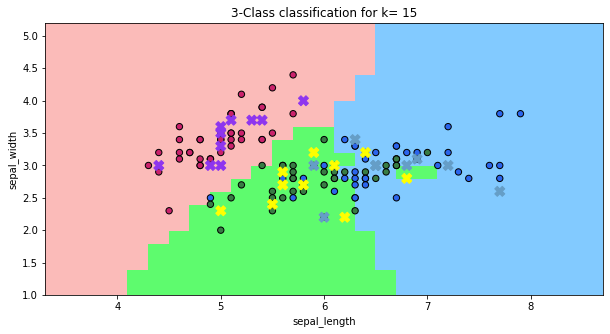

In [41]:
# for different value of k plotting the boundary and predicting the class label.
predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',2)
test_prediction_results(predicted_labels,y_test,labelencoder,2)
decision_boundary_plot(X_train,y_train,X_test,y_test,2,2)


predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',4)
test_prediction_results(predicted_labels,y_test,labelencoder,4)
decision_boundary_plot(X_train,y_train,X_test,y_test,4,2)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',6)
test_prediction_results(predicted_labels,y_test,labelencoder,6)
decision_boundary_plot(X_train,y_train,X_test,y_test,6,2)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',10)
test_prediction_results(predicted_labels,y_test,labelencoder,10)
decision_boundary_plot(X_train,y_train,X_test,y_test,10,2)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'euclidean',15)
test_prediction_results(predicted_labels,y_test,labelencoder,15)
decision_boundary_plot(X_train,y_train,X_test,y_test,15,2)







## Insights from the decision boundary plot with different values of K
1. when the k value is small the boundries are not smooth and the accuracy is less compared to a the a higher value of K.
2. and when value is very large then the boundries does get smooth but also opens up pockets.

Accuracy of this KNN classifer for k=2 is 0.933333


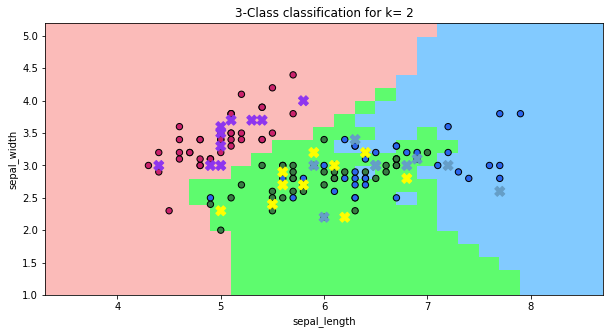

Accuracy of this KNN classifer for k=4 is 0.966667


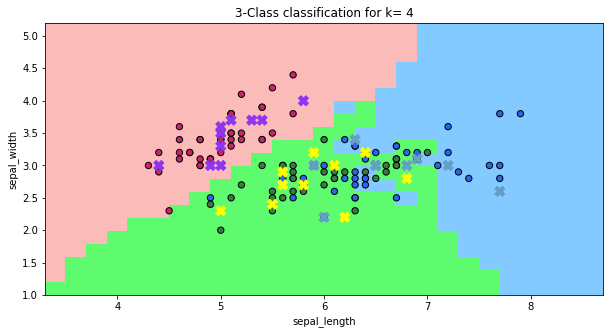

Accuracy of this KNN classifer for k=6 is 1.000000


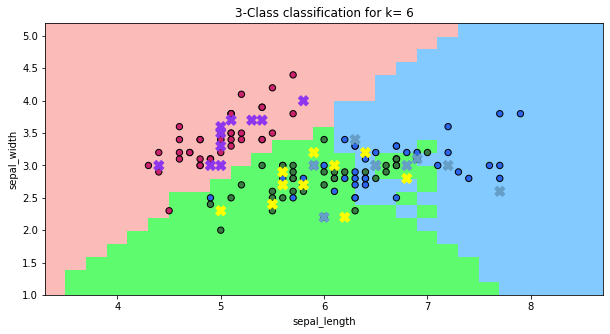

Accuracy of this KNN classifer for k=10 is 1.000000


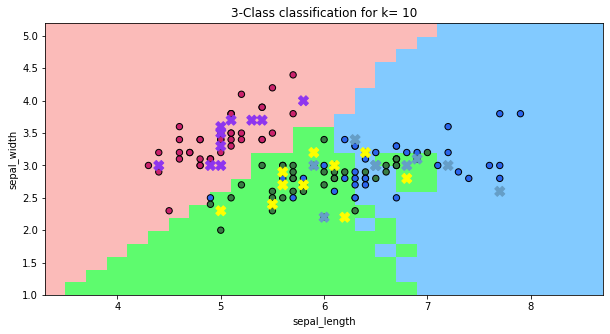

Accuracy of this KNN classifer for k=15 is 0.966667


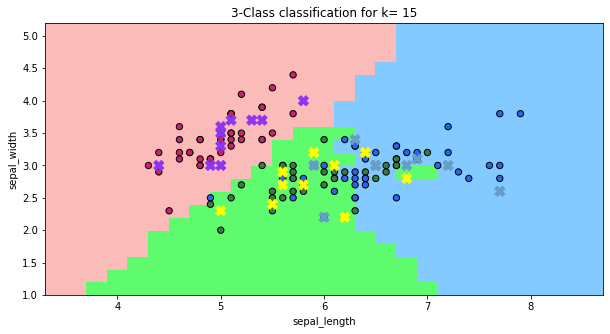

In [42]:
# for different value of k plotting the boundary and predicting the class label.
predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',2,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,2)
decision_boundary_plot(X_train,y_train,X_test,y_test,2,3)


predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',4,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,4)
decision_boundary_plot(X_train,y_train,X_test,y_test,4,3)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',6,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,6)
decision_boundary_plot(X_train,y_train,X_test,y_test,6,3)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',10,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,10)
decision_boundary_plot(X_train,y_train,X_test,y_test,10,3)



predicted_labels=k_nearest_neighbor(X_train,y_train,X_test,'minkowski',15,p=3)
test_prediction_results(predicted_labels,y_test,labelencoder,15)
decision_boundary_plot(X_train,y_train,X_test,y_test,15,3)

## Euclidean distance vs Minkowski distance
-I have used the stratified sampling and so the results are different everytime.  
1. There is change in which the grouping is done in both the classfication but the accuracy is almost the same.
2. Increase in the K value from 2 to 15 in both the metrics had a different result of accuracy for some test set.
3. The average accuracy for k=2,4,6,10,15 was about .98 for  minkowski distance almost the same for euclidean distance.


# Part 2

In [53]:
def k_nearest_neighbor_mnist(train_set,target_set,test_set,dist_type,k,**kwargs): 
    p = kwargs.get('p', 0)
    #calculate the distance between the points for each instance in test to the points in the training set
    Y=dist_measure.cdist(train_set, test_set,dist_type,p) 
    #converting to dataframe with columns as the test data index and indices as train set index
    #each entry in the dataframe represents the distance between [train_set instance][test_set_instance].
    Y=pd.DataFrame(Y)
    #creating the dictionary with the predicted value.
    answer={}
    #looping through each of the column(test set index) and getting the k nearest indices of the training set
    # and gettting the class label from the train set and using mode to predict the encoded class label.
    for test_point in Y.columns:
        indices=Y[test_point].nsmallest(k).index.to_list()
        predicted_label=[target_set.iloc[x] for x in indices ]
        answer[test_point]=predicted_label

    return pd.DataFrame(answer).mode().dropna().T.rename(columns={0:"predicted_label_value"}).astype({"predicted_label_value": 'int32'})

def test_prediction_results_mnist(predicted_value, actual_value,encoder,k):
    predicted_value['Actual_label_value']=list(actual_value)
#     predicted_value['predicted_label']=encoder.inverse_transform(predicted_value['predicted_label_value'])
#     print(predicted_value)
    accuracy=accuracy_score(predicted_value['predicted_label_value'],predicted_value['Actual_label_value'] )
    print("Accuracy of this KNN classifer for k=%d is %f"%(k,accuracy))

In [43]:
train_data= pd.read_csv('mnist_train.csv',header=None)
test_data=pd.read_csv('mnist_test.csv',header=None)
train_data.head(7)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:500,1:],train_data.iloc[:500,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.774000
CPU times: user 1.62 s, sys: 4.51 ms, total: 1.62 s
Wall time: 1.62 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,0,2
996,2,2
997,0,0
998,6,8


In [57]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:1000,1:],train_data.iloc[:1000,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.817000
CPU times: user 2.51 s, sys: 9.55 ms, total: 2.52 s
Wall time: 2.52 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,2,2
996,2,2
997,0,0
998,8,8


In [58]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:2500,1:],train_data.iloc[:2500,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.870000
CPU times: user 2.92 s, sys: 43.4 ms, total: 2.96 s
Wall time: 2.96 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,2,2
996,2,2
997,0,0
998,8,8


In [59]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:5000,1:],train_data.iloc[:5000,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.895000
CPU times: user 4.74 s, sys: 34.2 ms, total: 4.78 s
Wall time: 4.78 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,2,2
996,2,2
997,0,0
998,8,8


In [60]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:10000,1:],train_data.iloc[:10000,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.907000
CPU times: user 8.73 s, sys: 66.9 ms, total: 8.8 s
Wall time: 8.8 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,2,2
996,2,2
997,0,0
998,8,8


In [61]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:30000,1:],train_data.iloc[:30000,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.942000
CPU times: user 25.5 s, sys: 212 ms, total: 25.7 s
Wall time: 25.7 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,0,2
996,2,2
997,0,0
998,8,8


In [62]:
%%time
predicted_labels=k_nearest_neighbor_mnist(train_data.iloc[:60000,1:],train_data.iloc[:60000,0],test_data.iloc[:1000,1:],'euclidean',2)
test_prediction_results_mnist(predicted_labels,test_data.iloc[:1000,0],labelencoder,2)
# print(test_data.iloc[:1000,0])
predicted_labels

Accuracy of this KNN classifer for k=2 is 0.948000
CPU times: user 50.4 s, sys: 400 ms, total: 50.8 s
Wall time: 50.8 s


,predicted_label_value,Actual_label_value
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
995,0,2
996,2,2
997,0,0
998,8,8


In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predicted_labels['Actual_label_value'], predicted_labels['predicted_label_value'])


array([[ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 126,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   1, 108,   0,   1,   0,   0,   3,   0,   0],
       [  0,   0,   1, 101,   0,   3,   0,   2,   0,   0],
       [  1,   1,   0,   0, 105,   0,   0,   0,   0,   3],
       [  0,   0,   0,   3,   1,  83,   0,   0,   0,   0],
       [  2,   0,   0,   0,   1,   0,  84,   0,   0,   0],
       [  0,   2,   0,   2,   1,   0,   0,  94,   0,   0],
       [  2,   0,   2,   5,   2,   2,   1,   0,  74,   1],
       [  0,   0,   0,   1,   2,   0,   0,   2,   1,  88]])